# Time Headway Calculator

The goal of this notebook is to establish time headways for individual following events, as a histogram based on the speed of the following vehicle.

Authors: Sally Kim, Jonathan Sprinkle

In [53]:
import signal
import pandas as pd
import sys, math, time, datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
from matplotlib.pyplot import cm
import pickle
from strym import strymread
import strym
import copy

In [54]:
# removes the times during which the ACC is on and engaged, and returns a new strym object
def removeACC(strym_obj):
    frames = []
    
    timeslices = strym_obj.time_subset(conditions="cruise control on")
    df = strym_obj.dataframe
    # we have times when ACC is on, now we need to remove those times, so if 
    # our drive is from t0 to tN
    # acc is on from t1 to t2, t8 to t30, t50 to t65 ,then we'll have 
    # ( (t1, t2), (t8, t30), (t50, t65))
    # so we'll look to KEEP times
    # (0, t1), (t2, t8), (t30, t50), (t65, -1) 
#     print('Timeslices of acc on are:', timeslices)
#   JMS you have to check the first array value
#     if len(timeslices) < 1:
    if len(timeslices[0]) < 1:
#         print('Appending frames no matter what')
        frames.append(df)
    else:
        # always set the first one before the loop
#         print('doing the first one')
        import datetime as dt
        frame = df.loc[ pd.Timestamp(df.Time[0]) : timeslices[0][0][0]]
        frames.append(frame)
        for ii in range(len(timeslices[0])):
#             if ii == 0:
#             elif ii == len(timeslices[0])-1:
#                 frame = df.loc[ timeslices[0][ii][1] : ]
#             else:
            if ii > 0:
#                 print('doing a middle one from time ', timeslices[0][ii-1][1], ' to ', timeslices[0][ii][0])
                frame = df.loc[ timeslices[0][ii-1][1] : timeslices[0][ii][0]]
                frames.append(frame)
        # always do the last one
#         print('doing the last one')
        frame = df.loc [ timeslices[0][len(timeslices)-1][1]:pd.Timestamp(df.Time[-1]) ]
        frames.append(frame)
#     print(frames)
    # return the new dataframe(s), using style from strym
    result = copy.deepcopy(strym_obj)
    result_frames = pd.concat(frames)
    result.dataframe = result_frames
    return result, timeslices[0]

In [55]:
# change this to your data folder

#datafolder='/Users/sprinkle/work/data/sally/2021_08_09/'
datafolder='/Users/sallykim/Desktop/2021_08_09/'

import glob
csvlist = glob.glob(datafolder+"*2T3*CAN*.csv")

num_of_files = len(csvlist)
print("Total number of datafiles in {} is {}.".format(datafolder, num_of_files))
# dbcfile = '../examples/newToyotacode.dbc'

Total number of datafiles in /Users/sallykim/Desktop/2021_08_09/ is 3.


In [56]:
# choose the first file, and then plot the speed, as well as the lead vehicle distance
# Look in Minitest 1 or in 

#dbcfile_17 = '/Users/sallykim/opt/miniconda3/lib/python3.9/site-packages/strym/dbc/toyota_rav4_hybrid.dbc'
datafile_17 = datafolder+'2021-08-09-17-42-45_2T3Y1RFV8KC014025_CAN_Messages.csv'
#data_17 = pd.read_csv(datafile_17)


In [6]:
r00 = strymread(datafile_17)
r0, removed =removeACC(r00)

speed = r0.speed()
try:
    speed_17 = r0.get_ts('SPEED','SPEED')
    speed_17.Message = speed_17.Message*(1000/3600)
    long_dist_17 = r0.get_ts('LEAD_INFO','LEAD_LONG_DIST')
    long_dist_17_2 = r0.lead_distance()
except:
    print('Oops, a specific error message Sally writes')

[2022_07_21_14_38_32] (root) INFO: Vehicle model infered is toyota-rav4-2019


[Text(0.5, 17.00000000000003, 'Time (s) from start of drive'),
 Text(31.75, 0.5, 'Lead vehicle longitudinal distance (m)'),
 Text(0.5, 1.0, 'Lead Distance vs. Time')]

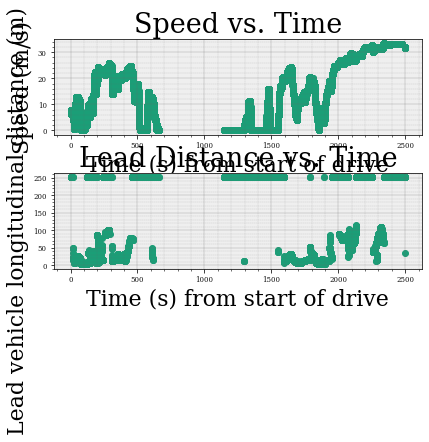

In [7]:
# choose the first file, and then plot the speed, as well as the lead vehicle distance
# Look in Minitest 1 or in 
fig, ax = strymread.create_fig(2)
ax[0].scatter(x=speed_17['Time'] - speed_17['Time'][0],y=speed_17['Message'])
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (m/s)',title='Speed vs. Time')
ax[1].scatter(x=long_dist_17_2['Time'] - long_dist_17_2['Time'][0],y=long_dist_17_2['Message'])
ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')

In [8]:
# find all times where the lead vehicle distance changes by more than 5

# 1. we're going to remove all times where we have >250 m and create chunks of data
lead_dist = long_dist_17_2
lead_dist_f = lead_dist[lead_dist["Message"]<200]

[Text(0.5, 94.72222222222219, 'Time (s) from start of drive'),
 Text(135.47222222222223, 0.5, 'Lead vehicle longitudinal distance (m)'),
 Text(0.5, 1.0, 'Lead Distance vs. Time')]

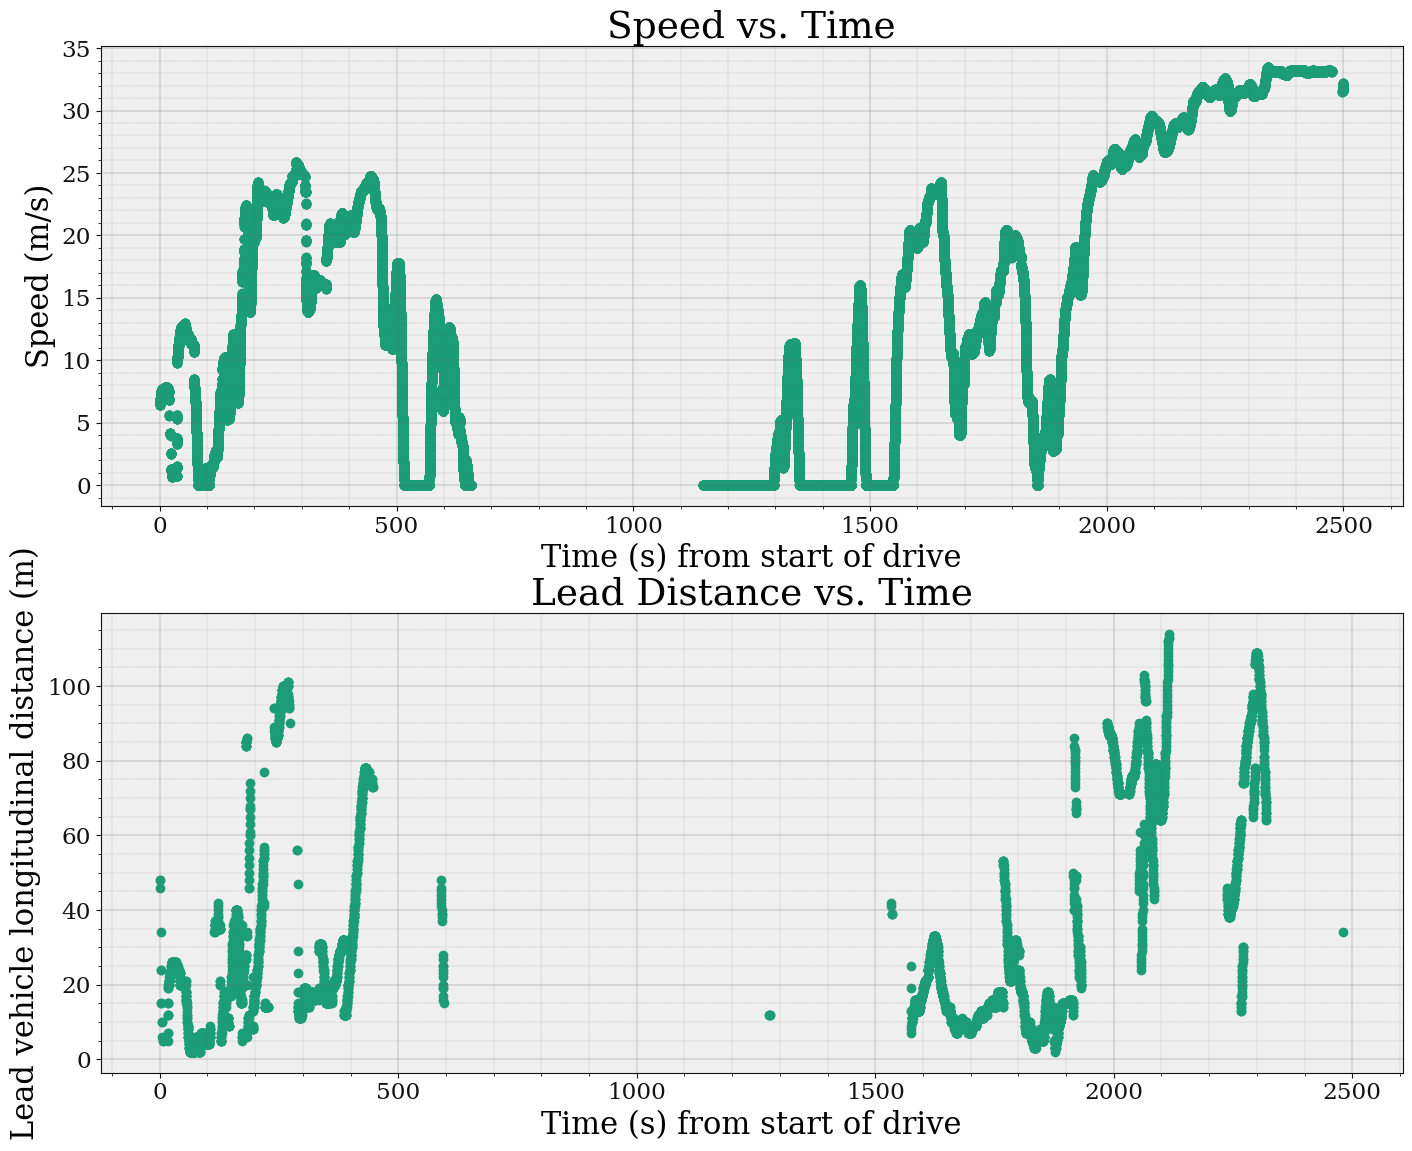

In [9]:
fig, ax = strymread.create_fig(2)
ax[0].scatter(x=speed_17['Time'] - speed_17['Time'][0],y=speed_17['Message'])
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (m/s)',title='Speed vs. Time')
ax[1].scatter(x=lead_dist_f['Time'] - lead_dist_f['Time'][0],y=lead_dist_f['Message'])
ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')

In [10]:
lead_dist_chunks = strymread.create_chunks(
        lead_dist_f,
        # look for any 'big' differences from time to time
        continuous_threshold=5,
        column_of_interest='Message',
#        plot=True,
    )

# now, remove any values where the duration of this chunk is less than 5 seconds
min_duration = 5
lead_dist_chunks_copy = lead_dist_chunks
for jj in reversed(range(len(lead_dist_chunks_copy))):
    chunk = lead_dist_chunks[jj]
    duration = chunk.Time[-1] - chunk.Time[0]
    if duration < min_duration:
        print('Removing element of duration ', duration)
        lead_dist_chunks.pop(jj)
    else:
        print('Keeping element of duration ', duration)

print('We now have ', len(lead_dist_chunks), ' drives that are longer than ', min_duration, ' seconds')

Removing element of duration  0.0
Keeping element of duration  23.60106110572815
Removing element of duration  4.000278949737549
Keeping element of duration  20.20098900794983
Removing element of duration  4.60017204284668
Keeping element of duration  29.40112614631653
Keeping element of duration  30.374499082565308
Keeping element of duration  21.000452995300293
Keeping element of duration  6.000230073928833
Removing element of duration  3.0703799724578857
Keeping element of duration  66.4016969203949
Removing element of duration  4.40029501914978
Keeping element of duration  6.20074987411499
Removing element of duration  0.5349910259246826
Removing element of duration  0.4003150463104248
Removing element of duration  2.399919033050537
Removing element of duration  1.7998030185699463
Keeping element of duration  39.801121950149536
Keeping element of duration  107.4036660194397
Keeping element of duration  191.60480308532715
Removing element of duration  0.0
Removing element of duratio

In [10]:
# next step: let's divide these up (if you can) OR you can instead try to calculate the time headway across these.
# to do that:
# 1) create a resampled version of two different timeseries
# e.g.,
# val1_sampled, val2_sampled = strymread.ts_sync(ts_val1, ts_val2)



speed = speed_17
lead_dist = lead_dist_chunks

result_speed = []
result_lead_dist = []
result_time_headway = []
time_headway = pd.DataFrame()

for lead_dist in lead_dist_chunks:
    speed_s, lead_dist_s = strymread.ts_sync(speed,lead_dist, method='nearest')
    result_speed.append(speed_s)
    #look for an exmaple where someone creates a new signal based on math with individual messages
    result_lead_dist.append(lead_dist_s)
    time_headway = speed_s[['Time','Message']].copy()
    time_headway['Message'] = lead_dist_s['Message'] / speed_s['Message']
    result_time_headway.append(time_headway)
# 2) divide the distance by the velocity to come up with the time headway
print( 'len(result_speed)=', len(result_speed), ', len(result_lead_dist)=', len(result_lead_dist), ', time headway = ', (len(result_time_headway)))


/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2767: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2820: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2767: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2820: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2767: FutureWarning:

The frame.append method 

len(result_speed)= 22 , len(result_lead_dist)= 22 , time headway =  22


NameError: name 'result_lead_dist' is not defined

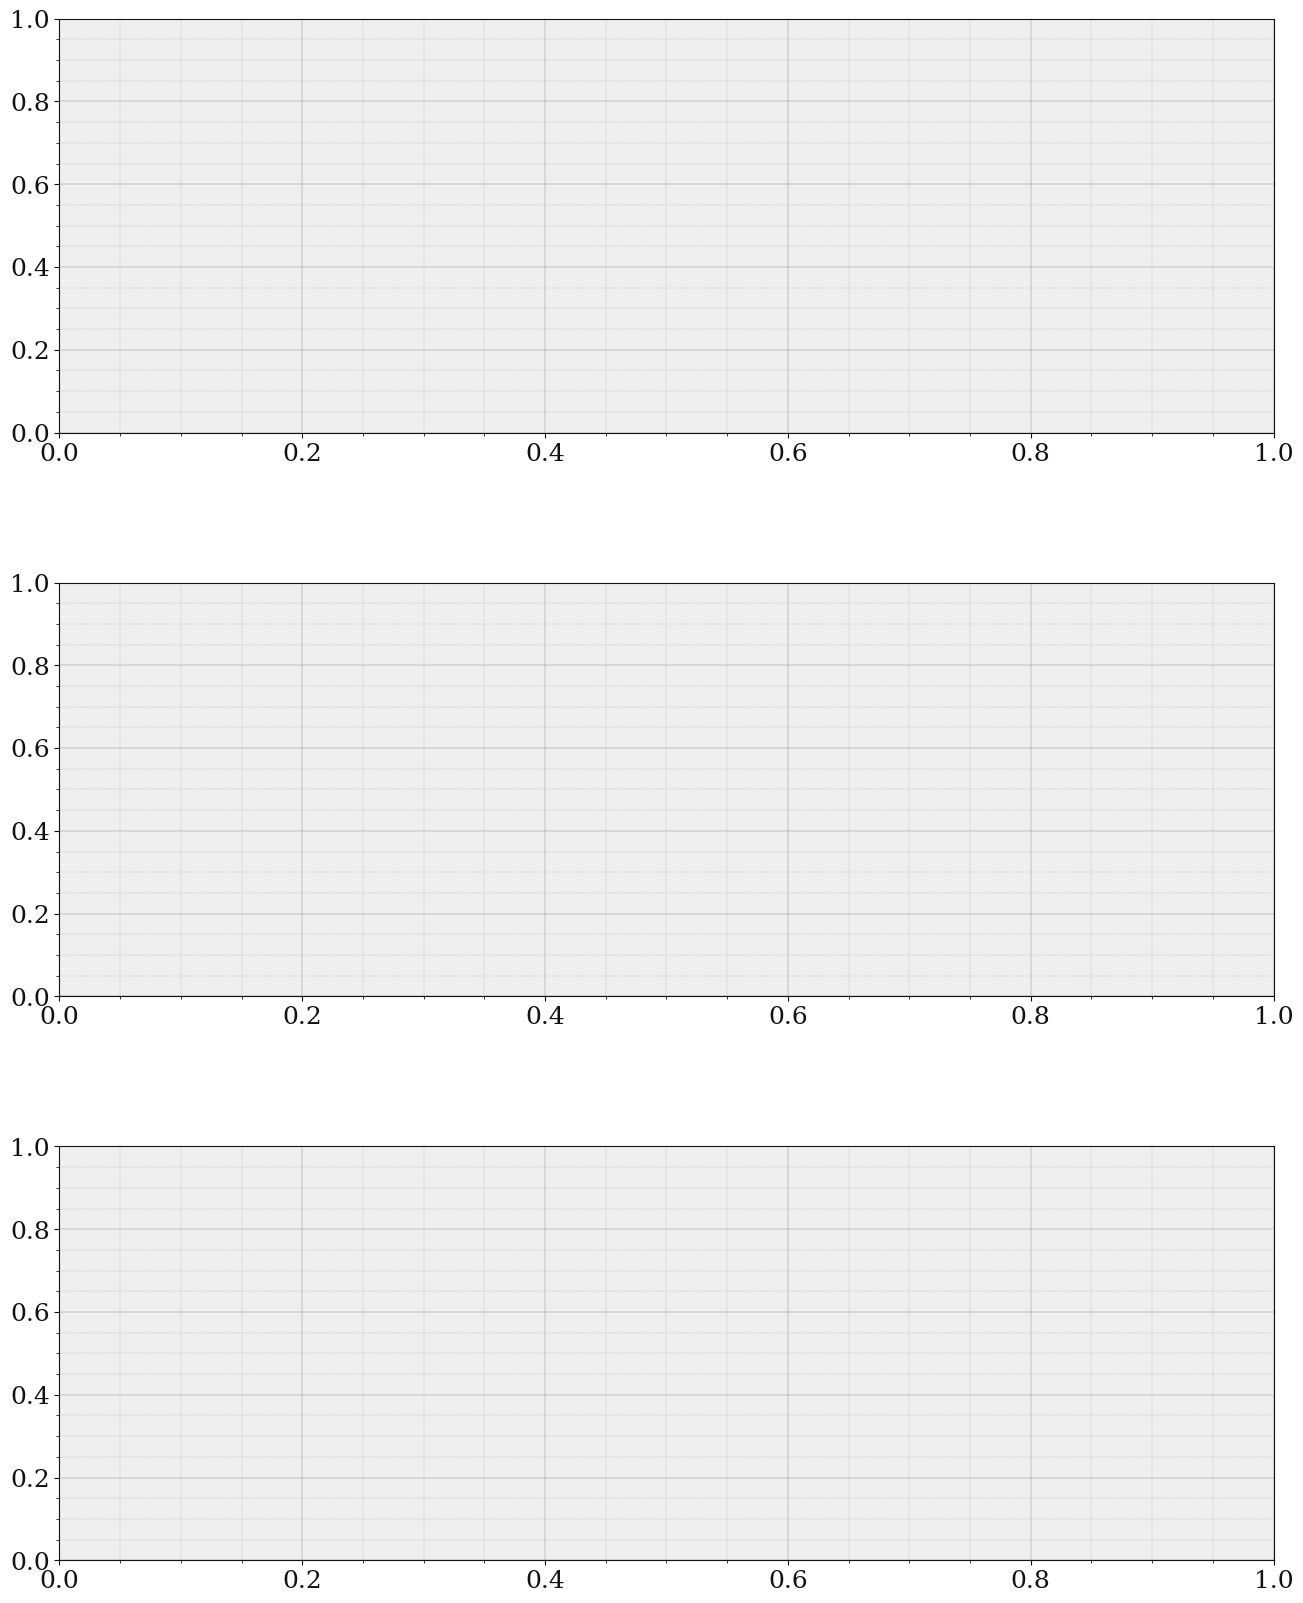

In [11]:
fig, ax = strymread.create_fig(3)

for jj in range(len(result_lead_dist)):
   ax[0].scatter(x=result_speed[jj]['Time'] - result_speed[jj]['Time'][0],y=result_speed[jj]['Message'])
   ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (m/s)',title='Speed vs. Time')
   ax[1].scatter(x=result_lead_dist[jj]['Time'] - result_lead_dist[jj]['Time'][0],y=result_lead_dist[jj]['Message'])
   ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')
   ax[2].scatter(x=result_time_headway[jj]['Time'] - result_time_headway[jj]['Time'][0],y=result_time_headway[jj]['Message'])
   ax[2].set(xlabel='Time (s) from start of drive',ylabel='Time Heaway (s)',title='Speed vs. Time')

(0.0, 5.0)

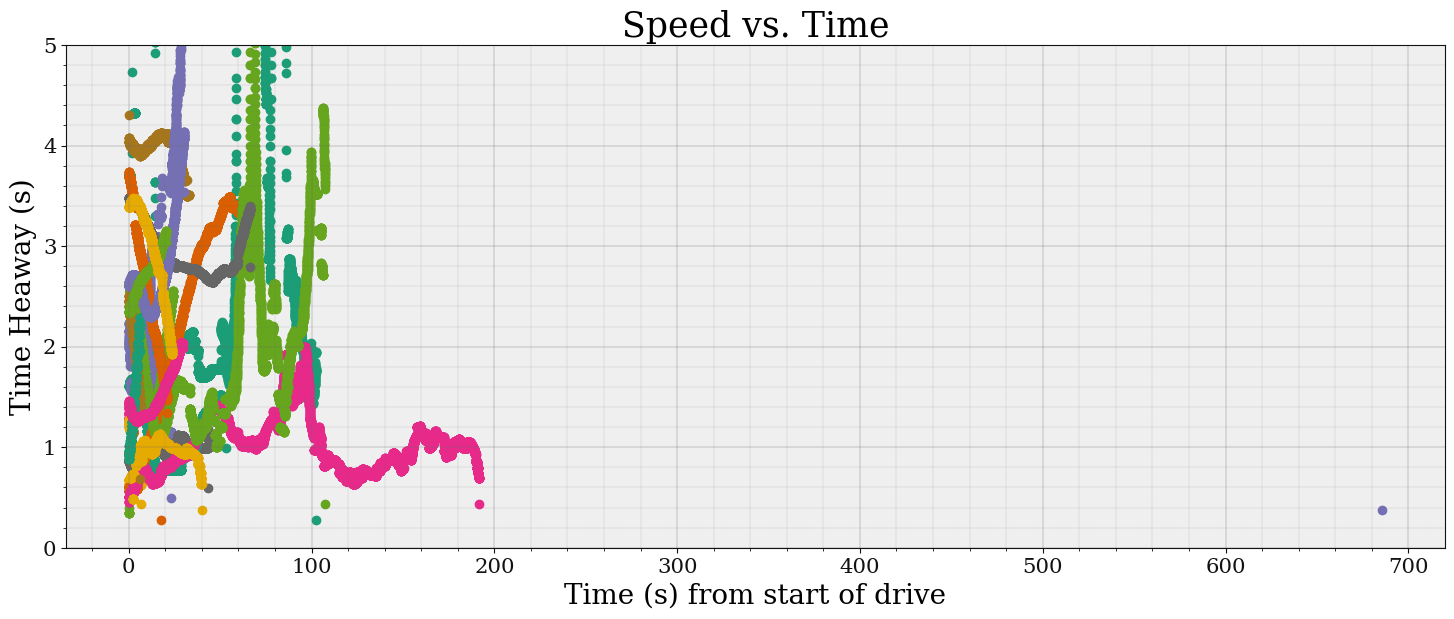

In [12]:
fig, ax = strymread.create_fig(1)

for jj in range(len(result_lead_dist)):
    ax[0].scatter(x=result_time_headway[jj]['Time'] - result_time_headway[jj]['Time'][0],y=result_time_headway[jj]['Message'])
    ax[0].set(xlabel='Time (s) from start of drive',ylabel='Time Heaway (s)',title='Speed vs. Time')
plt.ylim([0,5])


In [13]:
# remove all times where the lead vehicle distance is > 200

In [14]:
# print(result_speed)

In [40]:
def time2timeheadway(lead_dist_all,speed_subset):
    result = pd.DataFrame()
    speed_s, lead_dist_s = strymread.ts_sync(speed_subset,lead_dist_all, method='previous')
    time_headway = speed_s[['Time','Message']].copy()
    time_headway['Message'] = lead_dist_s['Message'] / speed_s['Message']
    return result, lead_dist_s

In [41]:
def plotDetails(speeds,lead_dists,time_headways):
    fig, ax = strymread.create_fig(3)
    for jj in range(len(lead_dists)):
        ax[0].scatter(x=speeds[jj]['Time'] - speeds[jj]['Time'][0],y=speeds[jj]['Message'])
        ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (m/s)',title='Speed vs. Time')
        ax[1].scatter(x=lead_dists[jj]['Time'] - lead_dists[jj]['Time'][0],y=lead_dists[jj]['Message'])
        ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')
        ax[2].scatter(x=time_headways[jj]['Time'] - time_headways[jj]['Time'][0],y=time_headways[jj]['Message'])
        ax[2].set(xlabel='Time (s) from start of drive',ylabel='Time Headway (s)',title='Time Headway')

reading file  /Users/sallykim/Desktop/2021_08_09/2021-08-09-18-34-50_2T3Y1RFV8KC014025_CAN_Messages.csv
[2022_07_21_16_27_12] (root) INFO: Vehicle model infered is toyota-rav4-2019
Removing element of duration  0.39957714080810547
We now have  0  drives that are longer than  5  seconds
len(result_speed)= 0 , len(result_lead_dist)= 0 , time headway =  0
reading file  /Users/sallykim/Desktop/2021_08_09/2021-08-09-17-42-45_2T3Y1RFV8KC014025_CAN_Messages.csv
[2022_07_21_16_27_19] (root) INFO: Vehicle model infered is toyota-rav4-2019
Removing element of duration  0.0
Keeping element of duration  23.60106110572815
Removing element of duration  4.000278949737549
Keeping element of duration  20.20098900794983
Removing element of duration  4.60017204284668
Keeping element of duration  29.40112614631653
Keeping element of duration  30.374499082565308
Keeping element of duration  21.000452995300293
Keeping element of duration  6.000230073928833
Removing element of duration  3.0703799724578857
Ke

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2767: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2820: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2767: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2820: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2767: FutureWarning:

The frame.append method 

len(result_speed)= 22 , len(result_lead_dist)= 22 , time headway =  22


/Users/sallykim/opt/miniconda3/lib/python3.8/site-packages/strym/strymread.py:2810: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



KeyError: 'Time'

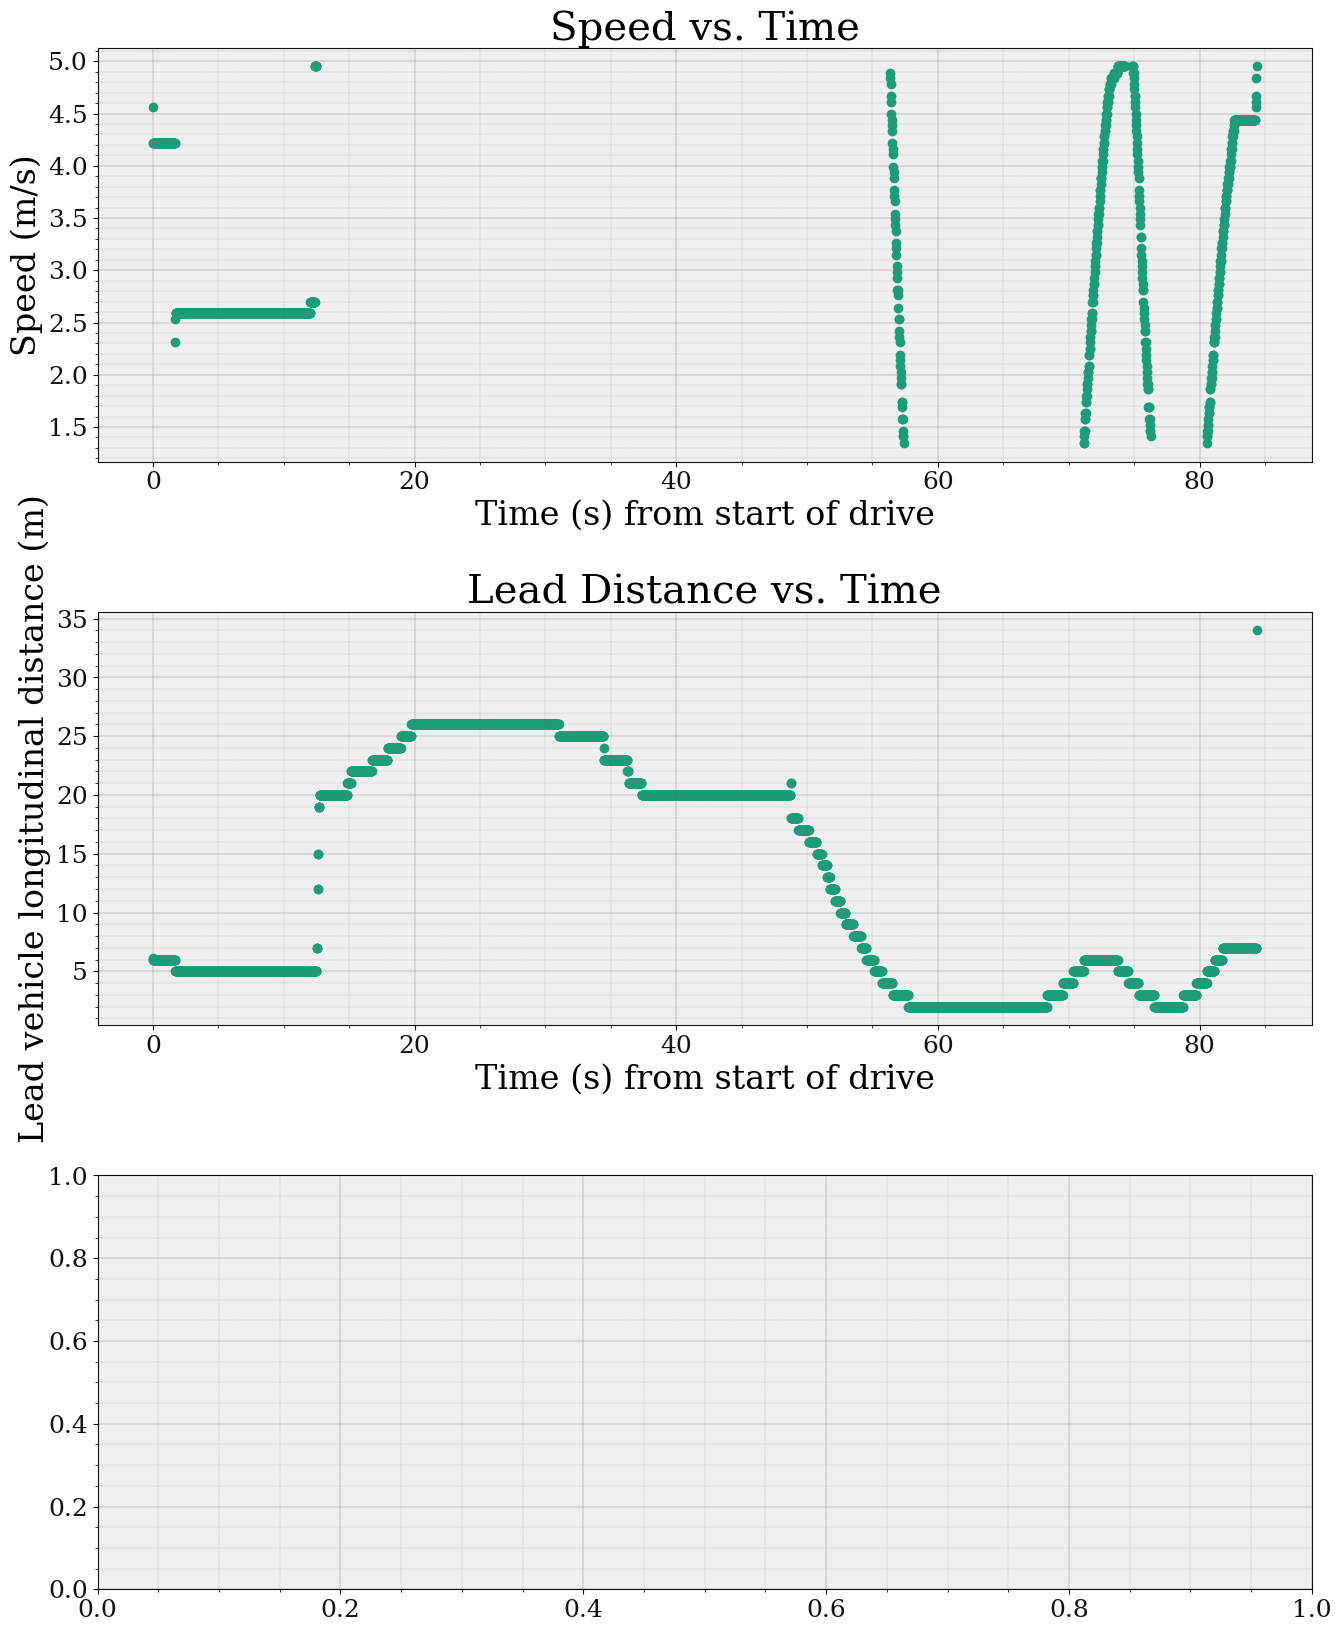

In [57]:
r0_v = []
r1_v = []
r2_v = []
r3_v = []
r4_v = []
r5_v = []

th0 = []
th1 = []
th2 = []
th3 = []
th4 = []
th5 = []

ld0 = []
ld1 = []
ld2 = []
ld3 = []
ld4 = []
ld5 = []

for file in csvlist:
    #read in the strym 
    print('reading file ', file)
    r00 = strymread(file)
    r0, removed = removeACC(r00)
    speed_17 = r0.speed()
    
    lead_dist = r0.lead_distance()
    lead_dist_f = lead_dist[lead_dist["Message"]<200]
    
    lead_dist_chunks = strymread.create_chunks(
            lead_dist_f,
            # look for any 'big' differences from time to time
            continuous_threshold=5,
            column_of_interest='Message',
    #        plot=True,
        )

    # now, remove any values where the duration of this chunk is less than 5 seconds
    min_duration = 5
    lead_dist_chunks_copy = lead_dist_chunks
    for jj in reversed(range(len(lead_dist_chunks_copy))):
        chunk = lead_dist_chunks[jj]
        duration = chunk.Time[-1] - chunk.Time[0]
        if duration < min_duration:
            print('Removing element of duration ', duration)
            lead_dist_chunks.pop(jj)
        else:
            print('Keeping element of duration ', duration)

    print('We now have ', len(lead_dist_chunks), ' drives that are longer than ', min_duration, ' seconds')

    speed = speed_17
#     lead_dist = lead_dist_chunks

    result_speed = []
    result_lead_dist = []
    result_time_headway = []
    time_headway = pd.DataFrame()

    for lead_dist in lead_dist_chunks:
        speed_s, lead_dist_s = strymread.ts_sync(speed,lead_dist, method='previous')
        result_speed.append(speed_s)
        
        #look for an exmaple where someone creates a new signal based on math with individual messages
        result_lead_dist.append(lead_dist_s)
        time_headway = speed_s[['Time','Message']].copy()
        time_headway['Message'] = lead_dist_s['Message'] / speed_s['Message']
        result_time_headway.append(time_headway)
    # 2) divide the distance by the velocity to come up with the time headway
    print( 'len(result_speed)=', len(result_speed), ', len(result_lead_dist)=', len(result_lead_dist), ', time headway = ', (len(result_time_headway)))
    
    for chunk in result_speed:
        # SALLY OK time to add in more regions here if you can. 
        
        region0 = chunk[(chunk['Message'] > 0) & (chunk['Message'] < 5)]
        if len(region0) > 0:
            try:
                r0_v.append(region0)
                th, ld = time2timeheadway(lead_dist_f, region0)
                th0.append(th)
                ld0.append(ld)
                #plotDetails(r0_v,ld0,th0)
            except:
                print('Something went wrong, continuing if we can')
        
        plotDetails(r0_v,ld0,th0)      
        
        # region1 =  chunk[(chunk['Message'] > 5) & (chunk['Message'] < 10)]
        # if len(region1) > 0:
        #     try:
        #         r1_v.append(region1)
        #         th, ld = time2timeheadway(lead_dist_f, region1)
#                 th1.append(th)
#                 ld1.append(ld)
#                 #plotDetails(r1_v,ld1,th1)
#             except:
#                 print('Something went wrong, continuing if we can')
        
        
#         region2 =  chunk[(chunk['Message'] > 10) & (chunk['Message'] < 15)]
#         if len(region2) > 0:
#             try:
#                 r2_v.append(region2)
#                 th, ld = time2timeheadway(lead_dist_f, region2)
#                 th2.append(th)
#                 ld2.append(ld)
#                 #plotDetails(r2_v,ld2,th2)
#             except:
#                 print('Something went wrong, continuing if we can')
        
        
#         region3 =  chunk[(chunk['Message'] > 15) & (chunk['Message'] < 20)]
#         if len(region3) > 0:
#             try:
#                 r3_v.append(region3)
#                 th, ld = time2timeheadway(lead_dist_f, region3)
#                 th3.append(th)
#                 ld3.append(ld)
#                 #plotDetails(r3_v,ld3,th3)
#             except:
#                 print('Something went wrong, continuing if we can')

        
#         region4 =  chunk[(chunk['Message'] > 20) & (chunk['Message'] < 25)]
#         if len(region4) > 0:
#             try:
#                 r4_v.append(region4)
#                 th, ld = time2timeheadway(lead_dist_f, region4)
#                 th4.append(th)
#                 ld4.append(ld)
#                 #plotDetails(r4_v,ld4,th4)
#             except:
#                 print('Something went wrong, continuing if we can')

        
#         region5 =  chunk[(chunk['Message'] > 25) & (chunk['Message'] < 30)]
#         if len(region5) > 0:
#             try:
#                 r5_v.append(region5)
#                 th, ld = time2timeheadway(lead_dist_f, region5)
#                 th5.append(th)
#                 ld5.append(ld)
#                 #plotDetails(r5_v,ld5,th5)
#             except:
#                 print('Something went wrong, continuing if we can')

In [170]:
# SALLY OK here we are, ready to print the results and add in more regions above. 

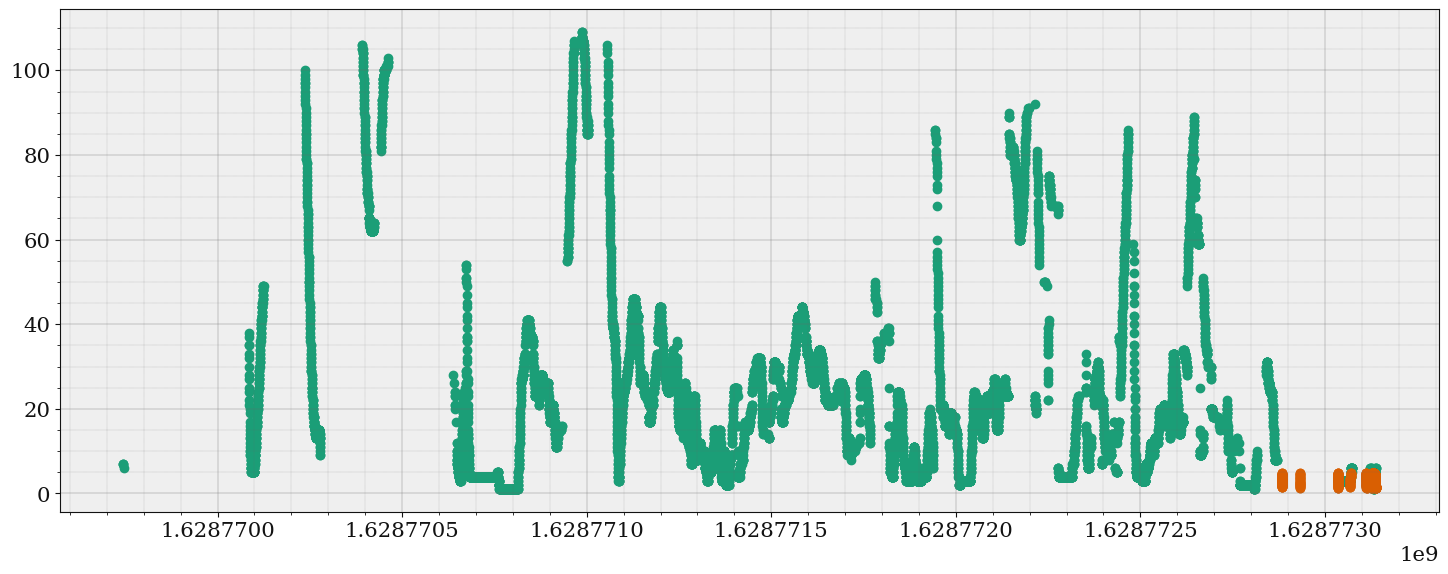

In [20]:
fix,ax = strymread.create_fig(1)
ax[0].scatter(x=lead_dist_f['Time'], y=lead_dist_f['Message'])
ax[0].scatter(x=region0['Time'],y=region0['Message'])


In [ ]:
r0_v = []

for chunk in result_speed:
    region0 = chunk[(chunk['Message'] > 0) & (chunk['Message'] < 5)]
    # only save it if it has nonzero length
    if len(region0) > 0:
        r0_v.append(region0)

At this point, you have figured out the times that make sense for velocity, but we have an array of those times, and there is a similar array of the other data (like lead vehicle distance), so we don't know where we are in each array unless we iterate over them all. So---we can either track 3 different iterators /or/ we can make a function that returns the values we want, based on the time values we have.

In [ ]:
# pass in the ENTIRE lead distance info, and then the speed dataframes for times where you want time headway.
# then it returns the time headway
def time2timeheadway(lead_dist_all,speed_subset):
    speed_s, lead_dist_s = strymread.ts_sync(speed_subset,lead_dist_all, method='previous')
    time_headway = speed_s[['Time','Message']].copy()
    time_headway['Message'] = lead_dist_s['Message'] / speed_s['Message']
    return time_headway, lead_dist_s

It looks like we're able to get those values now. Let's now iterate over ALL of the values by speed iteration.

In [ ]:
th0 = []
ld0 = []

for speed in r0_v:
#     region0 = time_headway[time_headway['Time'] == time['Time']]
#     region0 = time_headway.loc[time['Time']]
#     th0.append(region0)  
#     print(region0)
    th, ld = time2timeheadway(long_dist_17_2, speed)
    th0.append(th)
    ld0.append(ld)

In [15]:
def plotDetails(speeds,lead_dists,time_headways):
    fig, ax = strymread.create_fig(3)
    for jj in range(len(lead_dists)):
        ax[0].scatter(x=speeds[jj]['Time'] - speeds[jj]['Time'][0],y=speeds[jj]['Message'])
        ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (m/s)',title='Speed vs. Time')
        ax[1].scatter(x=lead_dists[jj]['Time'] - lead_dists[jj]['Time'][0],y=lead_dists[jj]['Message'])
        ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')
        ax[2].scatter(x=time_headways[jj]['Time'] - time_headways[jj]['Time'][0],y=time_headways[jj]['Message'])
        ax[2].set(xlabel='Time (s) from start of drive',ylabel='Time Headway (s)',title='Time Headway')

KeyError: 'Time'

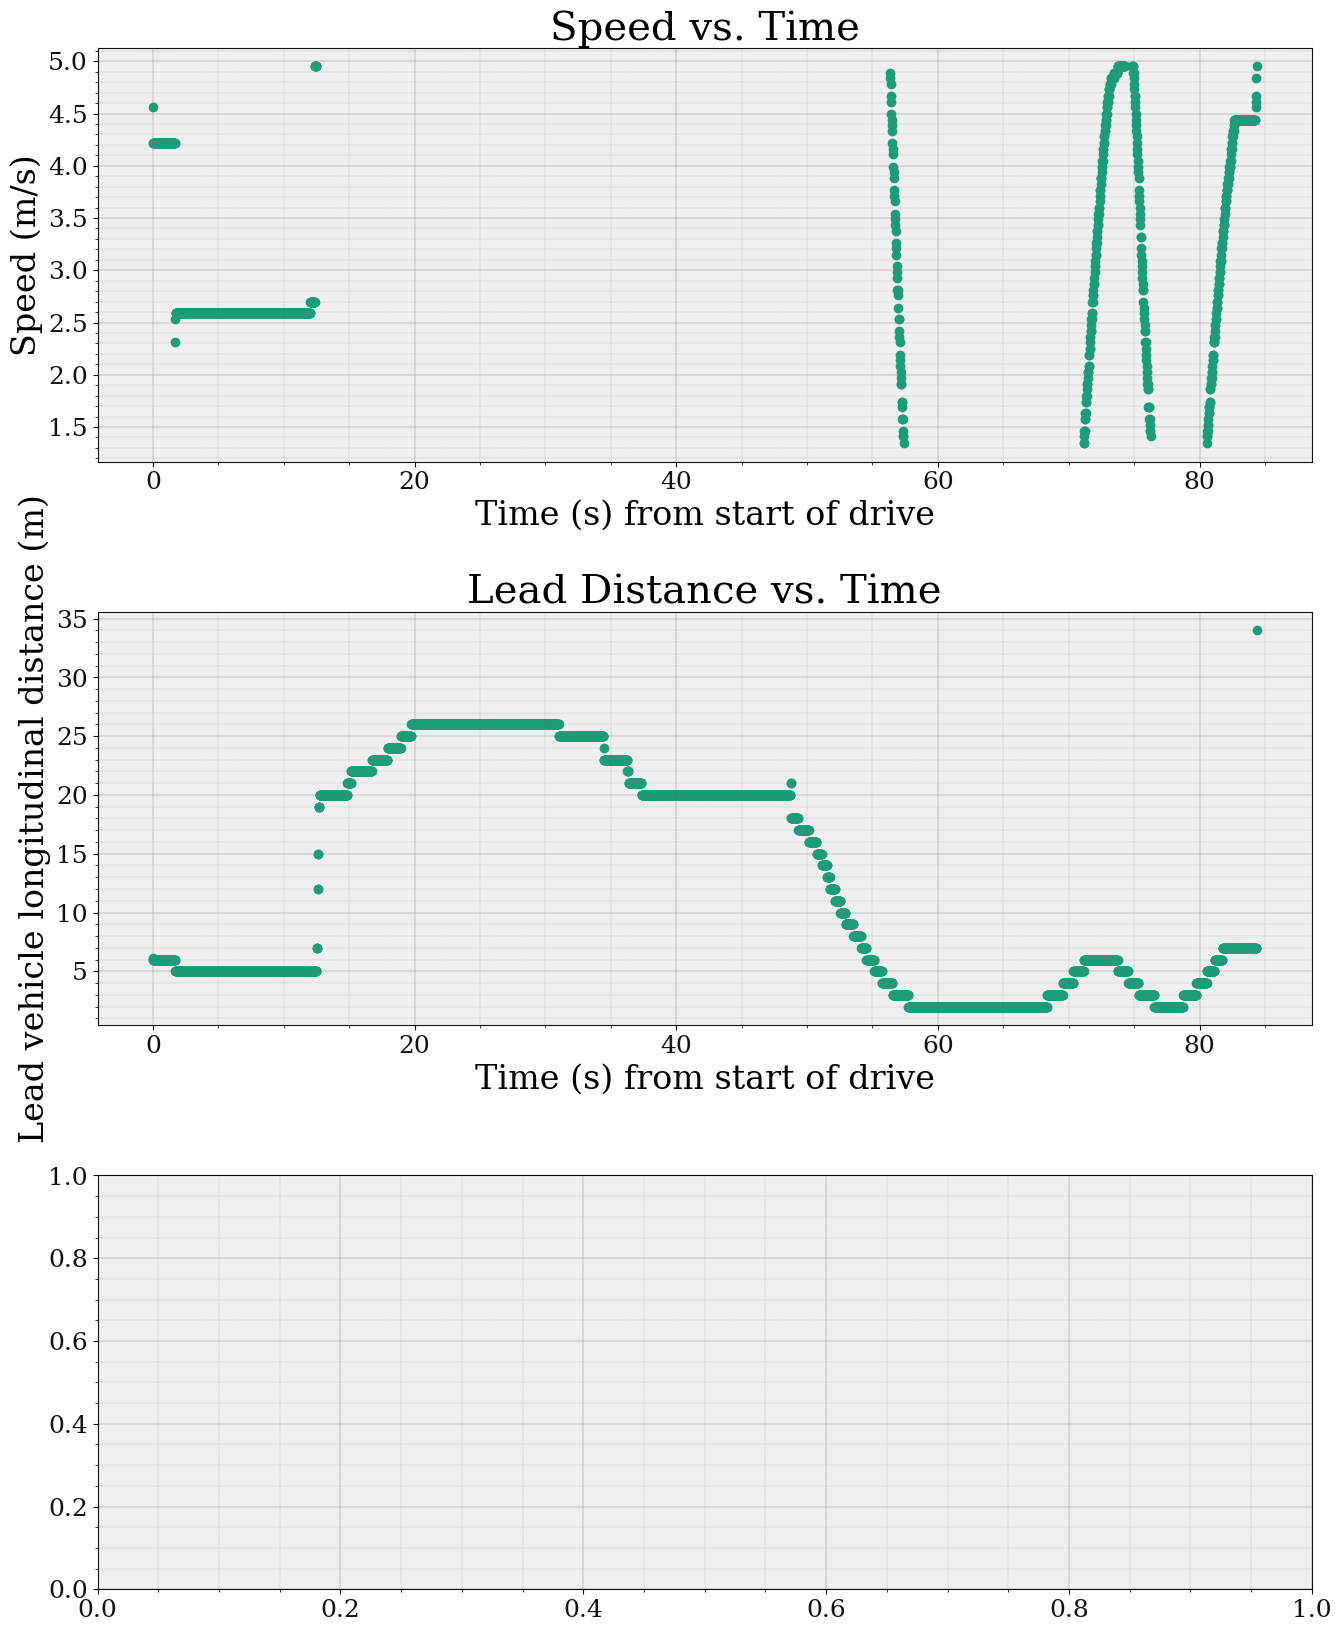

In [17]:
plotDetails(r0_v,ld0,th0)

Min: 0 s
Max: 680 s
Range: 680 s

In [ ]:
r1_v = []

for chunk in result_speed:
    region1 = chunk[(chunk['Message'] > 5) & (chunk['Message'] < 10)]
    # only save it if it has nonzero length
    if len(region1) > 0:
        r1_v.append(region1)

In [ ]:
th1 = []
ld1 = []

for speed in r1_v:
    th, ld = time2timeheadway(long_dist_17_2, speed)
    th1.append(th)
    ld1.append(ld)

In [ ]:
plotDetails(r1_v,ld1,th1)

Min: 0.2 s
Max: 18 s
Range: 17.8 s

In [ ]:
r2_v = []

for chunk in result_speed:
    region2 = chunk[(chunk['Message'] > 10) & (chunk['Message'] < 15)]
    # only save it if it has nonzero length
    if len(region2) > 0:
        r2_v.append(region2)

In [ ]:
th2 = []
ld2 = []

for speed in r2_v:
    th, ld = time2timeheadway(long_dist_17_2, speed)
    th2.append(th)
    ld2.append(ld)

In [ ]:
plotDetails(r2_v,ld2,th2)

Min: 0.5 s
Max: 7.5 s
Range: 7.0 s

In [ ]:
r3_v = []

for chunk in result_speed:
    region3 = chunk[(chunk['Message'] > 15) & (chunk['Message'] < 20)]
    # only save it if it has nonzero length
    if len(region3) > 0:
        r3_v.append(region3)
        
th3 = []
ld3 = []

for speed in r3_v:
    th, ld = time2timeheadway(long_dist_17_2, speed)
    th3.append(th)
    ld3.append(ld)
    
plotDetails(r3_v,ld3,th3)

Min: 0.2 s
Max: 2.5 s
Range: 2.3 s

In [ ]:
r4_v = []

for chunk in result_speed:
    region4 = chunk[(chunk['Message'] > 20) & (chunk['Message'] < 25)]
    # only save it if it has nonzero length
    if len(region4) > 0:
        r4_v.append(region4)
        
th4 = []
ld4 = []

for speed in r4_v:
    th, ld = time2timeheadway(long_dist_17_2, speed)
    th4.append(th)
    ld4.append(ld)
    
plotDetails(r4_v,ld4,th4)

Min: 0.25 s
Max: 4.5 s
Range: 4.25 s

In [ ]:
r5_v = []

for chunk in result_speed:
    region5 = chunk[(chunk['Message'] > 25) & (chunk['Message'] < 30)]
    # only save it if it has nonzero length
    if len(region5) > 0:
        r5_v.append(region5)
        
th5 = []
ld5 = []

for speed in r5_v:
    th, ld = time2timeheadway(long_dist_17_2, speed)
    th5.append(th)
    ld5.append(ld)
    
plotDetails(r5_v,ld5,th5)

Min: 0.1 s
Max: 4.2 s
Range: 4.1 s

In [ ]:
##file_list=['a.csv','b.csv','c.csv']
##TBD

  
#for i in range(1,len(file_list)):
